In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import scipy
pd.options.display.max_columns = None  # 显示所有列
pd.set_option('display.max_rows', None)
# 这两行代码解决 plt 中文显示的问题
plt.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['axes.unicode_minus'] = False

## 预处理

In [589]:
df = pd.read_excel(r'e:\desk\data_set\site_selection.xlsx', 'Sheet1')
# 添加经纬度 - 分析用
df1 = df.copy()
df1['latitude'] = [float(i.split(",",1)[1]) for i in df1.经纬度]  # 维度
df1['longitude'] = [float(i.split(",",1)[0]) for i in df1.经纬度]  # 经度
# 处理特殊字符
def char_columns(df):
    df = df.replace(r'\N', np.NAN)
    df = df.replace(r'缺', np.NAN)
    df = df.replace(r'无', np.NAN) 
    # NAN替换为固定值：未知
    # list1 = ['竞品销售分类', '盈利等级']
    # for i in list1:
    #     df[i] = df[i].fillna('未知')
    # NAN替换为固定值：0
    list1 = ['门头数', '华莱士', '竞品流量']
    for i in list1:
        df[i] = df[i].fillna(0)
    df['门头数'] = df['门头数'].replace(r'多', 3)
    # 用另外一列替换
    df['2020GDP'] = df['2020GDP'].fillna(df['2019GDP'])
    df['2020GDP'] = df['2020GDP'].fillna(0)
    return df

df1 = char_columns(df1)

# 用均值替换
df1['促销占比'] = df1['促销占比'].fillna(df1['促销占比'].mean())

# 删除缺失样本
def drop_null_value(df, to_drop_column):
    """
    这是一个删除缺失样本的函数
    :rtype: object
    """
    null_value = df[to_drop_column].isnull()
    df.drop(df[null_value].index, inplace=True)  # 删除异常样本
    df.index = range(df.shape[0])  # 删除之后, 恢复索引
    return df

df1 = drop_null_value(df1, '区县')

# 删除0值样本
def drop_lose_value(df, to_drop_column):
    """
    这是一个删除0值样本的函数
    :rtype: object
    """
    lose_value = df[to_drop_column] == 0
    df.drop(df[lose_value].index, inplace=True)  # 删除异常样本
    df.index = range(df.shape[0])  # 删除之后, 恢复索引
    return df

df1 = drop_lose_value(df1, '竞品流量')

def drop_extreme_value_s(df, to_drop_column):
    """
    使用正态分布的3倍标准差删除异常值的函数
    参数：
    df:要删除的含特征的数据框
    to_drop_column:字符串,要删除异常值的那一列的名称
    """

    # 要处理的特征
    df1 = df.loc[:, to_drop_column]
    # 计算判断异常点和极端异常点的临界值
    extreme_low = df1.mean() - 3 * df1.std()
    extreme_up = df1.mean() + 3 * df1.std()
    # 提取异常值
    extreme_value = df1[(df1 < extreme_low) | (df1 > extreme_up)]
    # 删除对应样本
    df2 = df.drop(extreme_value.index)
    # 删除之后, 恢复索引
    df2.index = range(df2.shape[0])
    # 打印删除样本量
    print(to_drop_column + ' 删除异常值样本：' + str(df1.shape[0] - df2.shape[0]))
    return df2

df1 = drop_extreme_value_s(df1, '竞品流量')

# 剔除竞品不合理的数据
df1 = df1.loc[(df1.竞品流量 >= 8) & (df1.竞品流量 <= 2800)]

# 剔除省份不合理的数据
df1 = df1.loc[(df1.商圈特性分区 != '大学城') & (df1.商圈特性分区 != '未维护')]
df1 = df1.loc[(df1.业态分类 != '购物中心')]
df1 = df1.loc[(df1.门头数 != 0)]
df1 = df1.loc[(df1.loc[:, '2020GDP'] != 0)]

竞品流量 删除异常值样本：1


In [590]:
sal_mean = 200 # 两百万店为好坏店判断标准
df1['good_bad'] = [1 if i > sal_mean else 0 for i in df1['满年业绩'].tolist()]
col2 = [
       '开业天数', 
       '二店数', 
       '餐饮数', '服饰数', '鞋店数', '内衣店数',
       '运动店数', '综合市场分类', '1000购物中心', '工厂分类', '商场数', 
       '业态分类',
       '省份', 
       # '城市', 
       '城市等级', 
       # '区县', 
       '主商圈', '副商圈', '商圈特性分区', '城乡分类', '门头数', '营销面积',
       '面积段', '促销占比', '区县生产总值（亿元）', 
       # '区县生产总值区间', 
       # '区县GDP年份',
       # '2019GDP', 
       '2020GDP', '七普（万人）', '六普（万人）', '1000综合市场', '1000长途汽车站', '1000火车站',
       '1000工厂', '1000普通商场', '竞品流量', '蜜雪冰城', '华莱士', '以纯', '海澜之家', '美特斯邦威',
       '爱依服', '森马', '大东', '卓诗尼', '都市丽人', '罗丽丝', '安踏', '特步', '满年业绩', '业绩段（实际+目标）', '业绩段（22年目标店型）', '坪效', 
       # '租金',
       'good_bad']
df2 = df1[col2]
# 平衡好坏样本数量
sample_0 = df2.loc[df2['good_bad'] == 0].shape[0]
df_sample_1 = df2.loc[df2['good_bad'] == 1].sample(sample_0)
df3 = pd.concat([df2.loc[df2['good_bad'] == 0], df_sample_1])

## 特征选择

In [591]:
# 划分数据集
X = df3.drop('good_bad', axis = 1)
y = df3['good_bad']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)
# 使用分类特征的卡方检验和数值特征的方差分析 F 统计量来识别最适合的二元分类问题的特征
X_train_cat = X.select_dtypes(include = 'object').copy()
X_train_num = X.select_dtypes(include = 'number').copy()

In [592]:
# 卡方过滤
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,Feature,p-value
0,商圈特性分区,0.000003
1,综合市场分类,0.000004
2,业态分类,0.000022
3,省份,0.006944
4,主商圈,0.011959
5,城乡分类,0.046250
6,城市等级,0.177786
7,工厂分类,0.252823
8,副商圈,0.266285
9,2020GDP,0.597789


In [594]:
# f_class_if 不接受缺失值，我们将对缺失值进行非常粗略的估算
X_train_num.fillna(X_train_num.mean(), inplace = True)
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_train_num, y)
# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,满年业绩,1481.819458,0.000000e+00
1,业绩段（22年目标店型）,1341.430909,0.000000e+00
2,业绩段（实际+目标）,1003.887182,0.000000e+00
3,坪效,634.879103,0.000000e+00
4,竞品流量,134.142793,0.000000e+00
5,开业天数,125.298049,0.000000e+00
6,营销面积,110.419303,0.000000e+00
7,面积段,93.216664,0.000000e+00
8,服饰数,52.566706,0.000000e+00
9,运动店数,48.456246,0.000000e+00


In [595]:
# 删除特征
drop_columns_list = ANOVA_F_table.iloc[33:, 0].to_list() # F-Score < 1
# drop_columns_list.extend(chi2_result.iloc[12:, 0].to_list()) # p-value
drop_columns_list.extend(['业绩段（22年目标店型）', '业绩段（实际+目标）', '面积段'
                         ,'开业天数','满年业绩', '坪效'
                         ,'省份'
                         # ,'综合市场分类'
                         ])

def col_to_drop(df, columns_list):
    df.drop(columns = columns_list, inplace = True)

# apply to X_train
col_to_drop(X, drop_columns_list)

In [597]:
X.shape

(1388, 36)

In [599]:
X.head(2)

,二店数,餐饮数,服饰数,鞋店数,内衣店数,运动店数,综合市场分类,1000购物中心,工厂分类,商场数,业态分类,城市等级,主商圈,副商圈,商圈特性分区,城乡分类,门头数,营销面积,区县生产总值（亿元）,2020GDP,七普（万人）,六普（万人）,1000综合市场,1000普通商场,竞品流量,蜜雪冰城,华莱士,以纯,海澜之家,爱依服,森马,卓诗尼,都市丽人,罗丽丝,安踏,特步
8,1,6,8,2,8,4,80以上,2,6,7,街铺,六线城市,农贸市场,工厂,社区,镇中心区,1,58.0,290.12,300以下,121.81,115.27,132,8,330.0,4,2,2,2,0,4,2,4,4,4,0
9,1,12,10,4,4,6,80以上,4,0,6,街铺,六线城市,农贸市场,工厂,社区,镇中心区,1,72.0,382.20,301-500,115.27,110.30,220,6,150.0,8,4,0,4,2,4,2,2,2,4,2


## 分箱

In [600]:
# Create copies of the 4 training sets to be preprocessed using WoE
X_train_prepr = X.copy()
y_train_prepr = y.copy()
# X_test_prepr = X_test.copy()
# y_test_prepr = y_test.copy()

In [601]:
# 训练集
a1 = pd.merge(X_train_prepr, y_train_prepr, on = X_train_prepr.index)
# a2 = pd.merge(X_test_prepr, y_test_prepr, on = X_test_prepr.index)

In [602]:
a1.columns[1:-1]

Index(['二店数', '餐饮数', '服饰数', '鞋店数', '内衣店数', '运动店数', '综合市场分类', '1000购物中心',
       '工厂分类', '商场数', '业态分类', '城市等级', '主商圈', '副商圈', '商圈特性分区', '城乡分类', '门头数',
       '营销面积', '区县生产总值（亿元）', '2020GDP', '七普（万人）', '六普（万人）', '1000综合市场',
       '1000普通商场', '竞品流量', '蜜雪冰城', '华莱士', '以纯', '海澜之家', '爱依服', '森马', '卓诗尼',
       '都市丽人', '罗丽丝', '安踏', '特步'],
      dtype='object')

#### 测试营销面积

In [192]:
# 测试营销面积

# 按照等频对需要分箱的列进行分箱
def qcut_bins(df, new_col, old_col):
    df[new_col], updown = pd.qcut(df[old_col], retbins=True, q=20, duplicates = 'drop')#等频分箱
    """
    pd.qcut，基于分位数的分箱函数，本质是将连续型变量离散化
    只能够处理一维数据。返回箱子的上限和下限
    参数q：要分箱的个数
    参数retbins=True来要求同时返回结构为索引为样本索引，元素为分到的箱子的Series
    updown：所有箱子的上限和下限
    """
    return df, updown
    
def get_woe(num_bins):
    # 通过 num_bins 数据计算 woe
    columns = ["min","max","count_0","count_1"]
    df = pd.DataFrame(num_bins,columns=columns)

    df["total"] = df.count_0 + df.count_1#一个箱子当中所有的样本数
    df["percent餐饮数"] = df.total / df.total.sum()#一个箱子里的样本数，占所有样本的比例
    df["bad_rate"] = df.count_1 / df.total#一个箱子坏样本的数量占一个箱子里边所有样本数的比例
    df["good%"] = df.count_0/df.count_0.sum()
    df["bad%"] = df.count_1/df.count_1.sum()
    df["woe"] = np.log(df["good%"] / df["bad%"])
    return df
 
#计算IV值
def get_iv(df):
    rate = df["good%"] - df["bad%"]
    iv = np.sum(rate * df.woe)
    return iv

In [195]:
aa = pd.merge(X_train_prepr, y_train_prepr, on = X_train_prepr.index)
aa["qcut"], updown = pd.qcut(aa["营销面积"], retbins=True, q=20, duplicates = 'drop')

In [196]:
# 统计每个分箱中0和1的数量
coount_y0 = aa[aa["good_bad"] == 0].groupby(by="qcut").count()["good_bad"]
coount_y1 = aa[aa["good_bad"] == 1].groupby(by="qcut").count()["good_bad"]
#num_bins值分别为每个区间的上界，下界，0出现的次数，1出现的次数
num_bins = [*zip(updown,updown[1:],coount_y0,coount_y1)]
#注意zip会按照最短列来进行结合
num_bins

[(15.0, 36.0, 48, 7),
 (36.0, 42.6, 36, 14),
 (42.6, 46.0, 43, 12),
 (46.0, 49.0, 33, 17),
 (49.0, 53.0, 30, 26),
 (53.0, 56.0, 35, 25),
 (56.0, 58.40000000000001, 20, 19),
 (58.40000000000001, 61.0, 31, 29),
 (61.0, 64.0, 28, 19),
 (64.0, 66.6, 22, 27),
 (66.6, 70.0, 32, 43),
 (70.0, 72.0, 16, 22),
 (72.0, 75.0, 25, 28),
 (75.0, 78.90000000000002, 20, 22),
 (78.90000000000002, 82.0, 27, 30),
 (82.0, 87.0, 14, 33),
 (87.0, 94.0, 23, 34),
 (94.0, 103.5, 11, 36),
 (103.5, 122.0, 12, 41),
 (122.0, 347.0, 14, 37)]

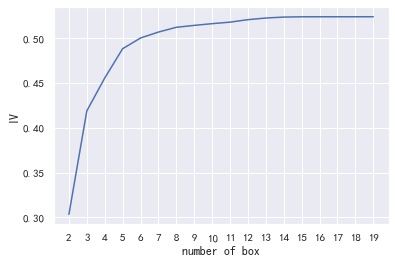

In [197]:
num_bins_ = num_bins.copy()
 
import matplotlib.pyplot as plt
import scipy
 
IV = []
axisx = []
 
while len(num_bins_) > 2:#大于设置的最低分箱个数
    pvs = []
    #获取 num_bins_两两之间的卡方检验的置信度（或卡方值）
    for i in range(len(num_bins_)-1):
        x1 = num_bins_[i][2:]
        x2 = num_bins_[i+1][2: ]
        # 0 返回 chi2 值，1 返回 p 值。
        pv = scipy.stats.chi2_contingency([x1,x2])[1]#p值
        # chi2 = scipy.stats.chi2_contingency([x1,x2])[0]#计算卡方值
        pvs.append(pv)
        
    # 通过 p 值进行处理。合并 p 值最大的两组
    i = pvs.index(max(pvs))
    num_bins_[i:i+2] = [(
            num_bins_[i][0],
            num_bins_[i+1][1],
            num_bins_[i][2]+num_bins_[i+1][2],
            num_bins_[i][3]+num_bins_[i+1][3])]
    
    bins_df = get_woe(num_bins_)
    axisx.append(len(num_bins_))
    IV.append(get_iv(bins_df))
    
plt.figure()
plt.plot(axisx,IV)
plt.xticks(axisx)
plt.xlabel("number of box")
plt.ylabel("IV")
plt.show()
#选择转折点处，也就是下坠最快的折线点，所以这里对于服饰数来说选择箱数为8

In [200]:
def get_bin(num_bins_,n):
    while len(num_bins_) > n:
        pvs = []
        for i in range(len(num_bins_)-1):
            x1 = num_bins_[i][2:]
            x2 = num_bins_[i+1][2:]
            pv = scipy.stats.chi2_contingency([x1,x2])[1]
            # chi2 = scipy.stats.chi2_contingency([x1,x2])[0]
            pvs.append(pv)

        i = pvs.index(max(pvs))
        num_bins_[i:i+2] = [(
                num_bins_[i][0],
                num_bins_[i+1][1],
                num_bins_[i][2]+num_bins_[i+1][2],
                num_bins_[i][3]+num_bins_[i+1][3])]
    return num_bins_
 
afterbins = get_bin(num_bins,8)
 
afterbins

[(15.0, 36.0, 48, 7),
 (36.0, 46.0, 79, 26),
 (46.0, 49.0, 33, 17),
 (49.0, 64.0, 144, 118),
 (64.0, 82.0, 142, 172),
 (82.0, 87.0, 14, 33),
 (87.0, 94.0, 23, 34),
 (94.0, 347.0, 37, 114)]

In [201]:
bins_df = get_woe(num_bins)
bins_df

,min,max,count_0,count_1,total,percent餐饮数,bad_rate,good%,bad%,woe
0,15.0,36.0,48,7,55,0.052834,0.127273,0.092308,0.013436,1.927212
1,36.0,46.0,79,26,105,0.100865,0.247619,0.151923,0.049904,1.113273
2,46.0,49.0,33,17,50,0.048031,0.340000,0.063462,0.032630,0.665215
3,49.0,64.0,144,118,262,0.251681,0.450382,0.276923,0.226488,0.201050
4,64.0,82.0,142,172,314,0.301633,0.547771,0.273077,0.330134,-0.189746
5,82.0,87.0,14,33,47,0.045149,0.702128,0.026923,0.063340,-0.855529
6,87.0,94.0,23,34,57,0.054755,0.596491,0.044231,0.065259,-0.388945
7,94.0,347.0,37,114,151,0.145053,0.754967,0.071154,0.218810,-1.123359


In [206]:
aa.loc[(aa.营销面积 >= 82) & (aa.营销面积 >= 87)].head(2)

,key_0,二店数,餐饮数,服饰数,鞋店数,内衣店数,运动店数,综合市场分类,1000购物中心,工厂分类,商场数,业态分类,城市等级,主商圈,副商圈,商圈特性分区,城乡分类,门头数,营销面积,区县生产总值（亿元）,2020GDP,七普（万人）,六普（万人）,1000综合市场,1000工厂,1000普通商场,竞品流量,华莱士,以纯,海澜之家,爱依服,森马,卓诗尼,都市丽人,罗丽丝,安踏,特步,good_bad,qcut
6,690,0,1,1,0,0,0,40-49,0,1,7,商超,三线城市,农贸市场,其它,社区,主城区,1,107.0,414.03,301-500,34.73,30.23,49,1,7,414.0,1,0,0,0,1,0,0,0,0,0,1,"(103.5, 122.0]"
8,949,0,1,0,0,0,1,40-49,0,7到9,0,商超,二线城市,工厂,学校,社区,主城区,1,99.0,808.15,501-1000,66.89,51.38,49,8,0,180.0,1,0,0,0,0,0,0,0,0,1,1,"(94.0, 103.5]"


#### 正式跑

---

In [603]:
def graphforbestbin(DF, X, Y, n=5,q=20,graph=True):
    '''
    自动最优分箱函数，基于卡方检验的分箱

    参数：
    DF: 需要输入的数据
    X: 需要分箱的列名
    Y: 分箱数据对应的标签 Y 列名
    n: 保留分箱个数
    q: 初始分箱的个数
    graph: 是否要画出IV图像

    区间为前开后闭 (]

    '''
    
    DF = DF[[X,Y]].copy()

    DF["qcut"],bins = pd.qcut(DF[X], retbins=True, q=q,duplicates="drop")
    coount_y0 = DF.loc[DF[Y]==0].groupby(by="qcut").count()[Y]
    coount_y1 = DF.loc[DF[Y]==1].groupby(by="qcut").count()[Y]
    num_bins = [*zip(bins,bins[1:],coount_y0,coount_y1)]

    for i in range(q):
        if 0 in num_bins[0][2:]:
            num_bins[0:2] = [(
                num_bins[0][0],
                num_bins[1][1],
                num_bins[0][2]+num_bins[1][2],
                num_bins[0][3]+num_bins[1][3])]
            continue

        for i in range(len(num_bins)):
            if 0 in num_bins[i][2:]:
                num_bins[i-1:i+1] = [(
                    num_bins[i-1][0],
                    num_bins[i][1],
                    num_bins[i-1][2]+num_bins[i][2],
                    num_bins[i-1][3]+num_bins[i][3])]
                break
        else:
            break

    def get_woe(num_bins):
        columns = ["min","max","count_0","count_1"]
        df = pd.DataFrame(num_bins,columns=columns)
        df["total"] = df.count_0 + df.count_1
        df["percent"] = df.total / df.total.sum()
        df["bad_rate"] = df.count_1 / df.total
        df["good%"] = df.count_0/df.count_0.sum()
        df["bad%"] = df.count_1/df.count_1.sum()
        df["woe"] = np.log(df["good%"] / df["bad%"])
        return df

    def get_iv(df):
        rate = df["good%"] - df["bad%"]
        iv = np.sum(rate * df.woe)
        return iv

    IV = []
    axisx = []
    while len(num_bins) > n:
        pvs = []
        for i in range(len(num_bins)-1):
            x1 = num_bins[i][2:]
            x2 = num_bins[i+1][2:]
            pv = scipy.stats.chi2_contingency([x1,x2])[1]
            pvs.append(pv)

        i = pvs.index(max(pvs))
        num_bins[i:i+2] = [(
            num_bins[i][0],
            num_bins[i+1][1],
            num_bins[i][2]+num_bins[i+1][2],
            num_bins[i][3]+num_bins[i+1][3])]
        
        global bins_df
        bins_df = pd.DataFrame(get_woe(num_bins))
        axisx.append(len(num_bins))
        IV.append(get_iv(bins_df))
        
    if graph:
        plt.figure()
        plt.plot(axisx,IV)
        plt.xticks(axisx)
        plt.xlabel("number of box")
        plt.ylabel("IV")
        plt.show()
    return bins_df

### 自动分箱只处理数值特征

二店数


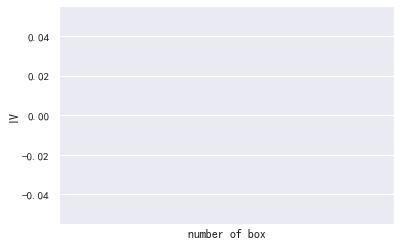

餐饮数


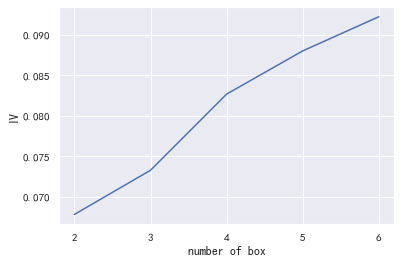

服饰数


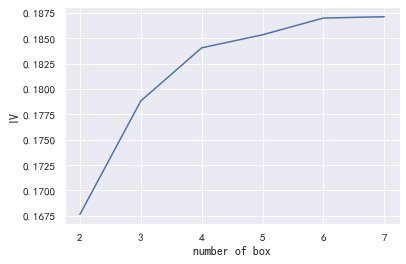

鞋店数


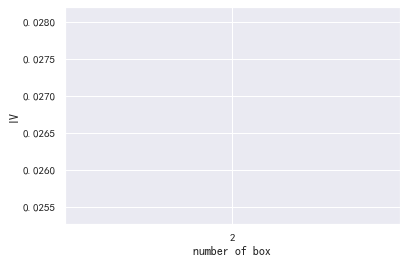

内衣店数


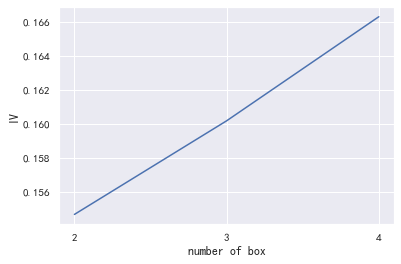

运动店数


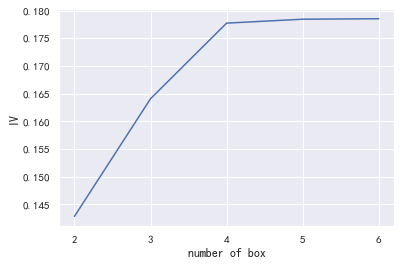

1000购物中心


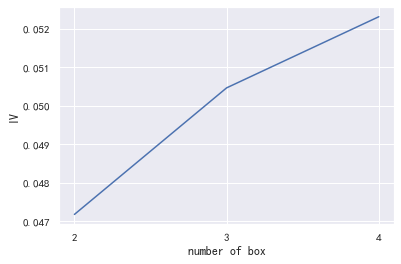

商场数


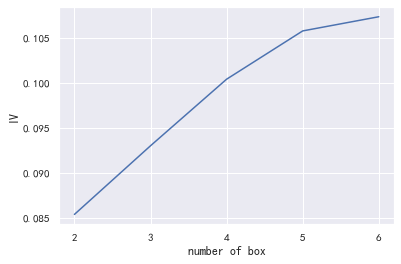

门头数


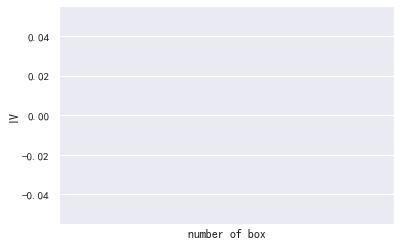

营销面积


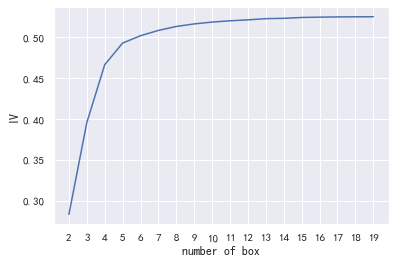

区县生产总值（亿元）


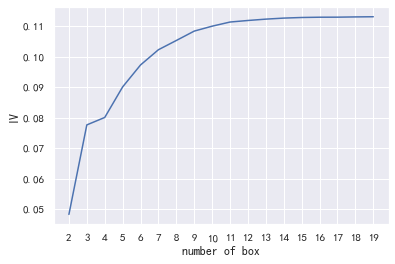

七普（万人）


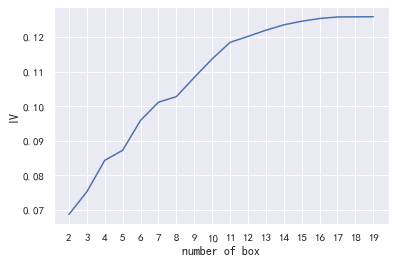

1000综合市场


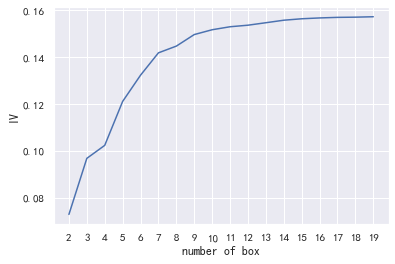

1000普通商场


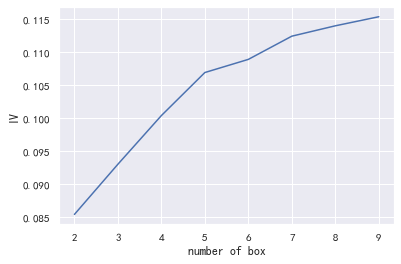

竞品流量


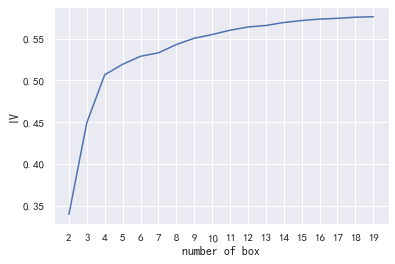

蜜雪冰城


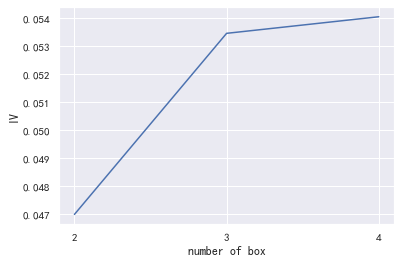

华莱士


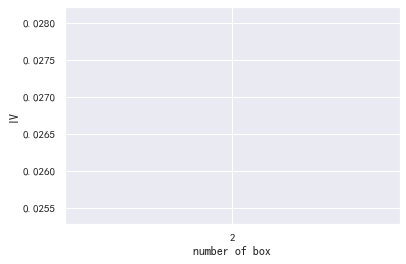

以纯


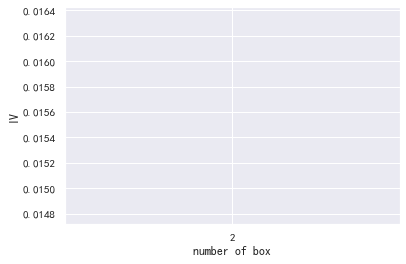

海澜之家


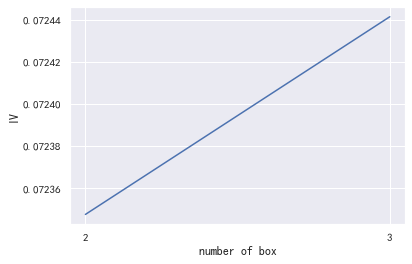

爱依服


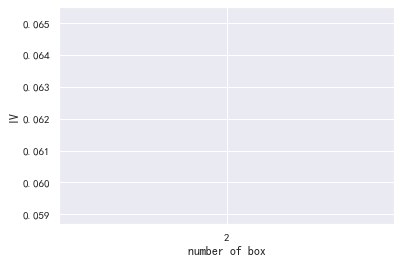

森马


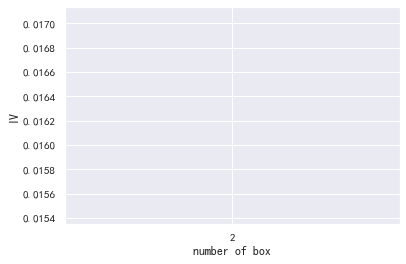

卓诗尼


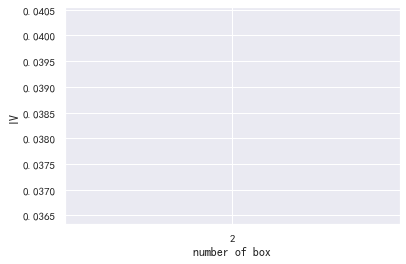

都市丽人


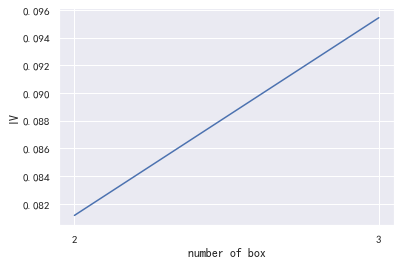

罗丽丝


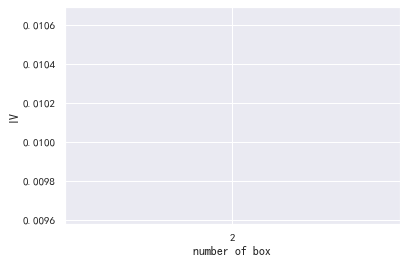

安踏


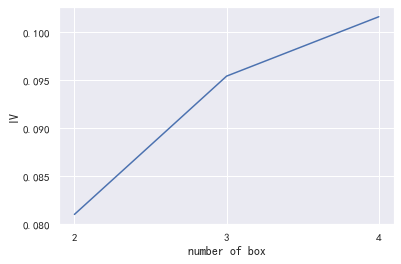

特步


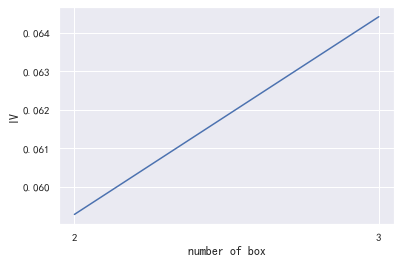

In [604]:
listA = a1.columns.to_list()
listB = ANOVA_F_table.iloc[:32, 0].to_list()
value_col = [i for i in listA if i in listB]

for i in value_col:
    print(i)
    graphforbestbin(a1,i,"good_bad",n=2,q=20)

In [605]:
# 自动分箱的变量
auto_col_bins = {"餐饮数":4,
                 "服饰数":6,
                 "内衣店数":4,
                 "运动店数":5,
                 "1000购物中心":3,
                 "1000综合市场":10,
                 "1000普通商场":8,
                 "海澜之家":3,
                 "特步":3,
                 "安踏":3,
                 "竞品流量":4,
                 "营销面积":6
                }
 
#不能使用自动分箱的变量
hand_bins = {
            '二店数':[0, 1]
            ,"门头数":[1, 2]
            ,"森马":[0, 1]
            ,"鞋店数":[0, 1]
            ,"爱依服":[0, 1]
            ,"以纯":[0, 1, 2]
            ,"安踏":[0, 1, 2]
            ,"爱依服":[0, 1, 2]
            ,"罗丽丝":[0, 1, 2]
            ,"卓诗尼":[0, 1, 2]
            ,"都市丽人":[0, 1, 2]
            ,"华莱士":[0, 1, 2]
            }

#保证区间覆盖使用 np.inf替换最大值，用-np.inf替换最小值 
#原因：比如一些新的值出现，例如家庭人数为30，以前没出现过，改成范围为极大值之后，这些新值就都能分到箱里边了
hand_bins = {k:[-np.inf,*v[:-1],np.inf] for k,v in hand_bins.items()}

In [606]:
bins_of_col = {}
 
# 生成自动分箱的分箱区间和分箱后的 IV 值
 
for col in auto_col_bins:
    bins_df = graphforbestbin(a1,col
                             ,"good_bad"
                             ,n=auto_col_bins[col]
                             #使用字典的性质来取出每个特征所对应的箱的数量
                             ,q=20
                             ,graph=False)
    bins_list = sorted(set(bins_df["min"]).union(bins_df["max"]))
    #保证区间覆盖使用 np.inf 替换最大值 -np.inf 替换最小值
    bins_list[0],bins_list[-1] = -np.inf,np.inf
    bins_of_col[col] = bins_list
    
#合并手动分箱数据    
bins_of_col.update(hand_bins)

In [607]:
bins_of_col

{'餐饮数': [-inf, 2.0, 3.0, 6.0, inf],
 '服饰数': [-inf, 1.0, 2.0, 3.0, 6.0, 7.0, inf],
 '内衣店数': [-inf, 1.0, 3.0, 4.0, inf],
 '运动店数': [-inf, 1.0, 2.0, 5.0, 6.0, inf],
 '1000购物中心': [-inf, 1.0, 2.0, inf],
 '1000综合市场': [-inf,
  27.0,
  44.0,
  50.0,
  60.0,
  65.0,
  80.90000000000009,
  86.0,
  98.0,
  162.0,
  inf],
 '1000普通商场': [-inf, 1.0, 2.0, 3.0, 4.0, 5.0, 8.0, 9.0, inf],
 '海澜之家': [-inf, 1.0, 3.0, inf],
 '特步': [-inf, 1.0, 3.0, inf],
 '安踏': [-inf, 0, 1, inf],
 '竞品流量': [-inf, 180.0, 480.0, 1130.0, inf],
 '营销面积': [-inf, 36.535000000000004, 42.4, 49.38, 64.0, 83.0, inf],
 '二店数': [-inf, 0, inf],
 '门头数': [-inf, 1, inf],
 '森马': [-inf, 0, inf],
 '鞋店数': [-inf, 0, inf],
 '爱依服': [-inf, 0, 1, inf],
 '以纯': [-inf, 0, 1, inf],
 '罗丽丝': [-inf, 0, 1, inf],
 '卓诗尼': [-inf, 0, 1, inf],
 '都市丽人': [-inf, 0, 1, inf],
 '华莱士': [-inf, 0, 1, inf]}

In [608]:
hot_col = ['商圈特性分区','综合市场分类','业态分类','城市等级',
           '城乡分类','门头数','主商圈','工厂分类','2020GDP',
           '副商圈']

In [609]:
# 分类特征
def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [611]:
def get_woe(df,col,y,bins):
    df = df[[col,y]].copy()
    df["cut"] = pd.cut(df[col],bins)
    bins_df = df.groupby("cut")[y].value_counts().unstack()
    woe = bins_df["woe"] = np.log((bins_df[0]/bins_df[0].sum())/(bins_df[1]/bins_df[1].sum()))
    return woe
 
#将所有数值特征的WOE存储到字典当中
woeall = {}
for col in bins_of_col:
    woeall[col] = get_woe(a1,col,"good_bad",bins_of_col[col])
for col in hot_col:
    p1 = woe_discrete(a1.iloc[:,:-1], col, a1.iloc[:,-1]).loc[:, [col, 'WoE']]
    woeall[col] = p1.set_index(p1[col]).loc[:, 'WoE']

In [612]:
woeall['商圈特性分区']

商圈特性分区
校区     -0.693147
社区     -0.622396
批发市场   -0.441833
城中村    -0.271934
地下街    -0.167054
景区      0.223144
工厂      0.302281
街边店     0.448950
步行街     0.693147
Name: WoE, dtype: float64

In [613]:
col = '商圈特性分区'
woe_discrete(a1.iloc[:,:-1], col, a1.iloc[:,-1]).loc[:, [col, 'WoE']]

,商圈特性分区,WoE
0,校区,-0.693147
1,社区,-0.622396
2,批发市场,-0.441833
3,城中村,-0.271934
4,地下街,-0.167054
5,景区,0.223144
6,工厂,0.302281
7,街边店,0.448950
8,步行街,0.693147


In [614]:
col = '商圈特性分区'
woe_discrete(a2.iloc[:,:-1], col, a2.iloc[:,-1]).loc[:, [col, 'WoE']]

C:\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,商圈特性分区,WoE
0,批发市场,-inf
1,社区,-0.905386
2,校区,-0.687383
3,城中村,-0.281918
4,工厂,0.128366
5,街边店,0.649314
6,地下街,0.922054
7,步行街,1.286698
8,景区,inf


In [615]:
#不希望覆盖掉原本的数据，创建一个新的DataFrame，索引和原始数据aa一模一样
model_woe = pd.DataFrame(index=a1.index)
model_woe_test = pd.DataFrame(index=a2.index)
 
#将原数据分箱后，按箱的结果把WOE结构用map函数映射到数据中
# model_woe["餐饮数"] = pd.cut(a1["餐饮数"],bins_of_col["餐饮数"]).map(woeall["餐饮数"])
 
#对所有特征操作可以写成：
for col in bins_of_col:
    model_woe[col] = pd.cut(a1[col],bins_of_col[col]).map(woeall[col])
    model_woe_test[col] = pd.cut(a2[col],bins_of_col[col]).map(woeall[col])
    
for col in hot_col:
    p1 = woe_discrete(a1.iloc[:,:-1], col, a1.iloc[:,-1]).loc[:, [col, 'WoE']]
    # p2 = woe_discrete(a2.iloc[:,:-1], col, a2.iloc[:,-1]).loc[:, [col, 'WoE']]
    model_woe[col] = a1[col].map(p1.set_index(p1[col]).loc[:, 'WoE'])
    # model_woe_test[col] = a2[col].map(p2.set_index(p2[col]).loc[:, 'WoE'])
    
#将标签补充到数据中
model_woe["good_bad"] = a1["good_bad"]
model_woe_test["good_bad"] = a2["good_bad"]

In [616]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [617]:
model_woe = clean_dataset(model_woe)
X = model_woe.iloc[:,:-1]
y = model_woe.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

## 建模

In [618]:
from sklearn.linear_model import LogisticRegression as LR

lr = LR().fit(X,y)
# 系数
print("lr.coef_:{}",format(lr.coef_))
# 截距
print("lr.intercept_:{}",format(lr.intercept_))
lr.score(X,y)

lr.coef_:{} [[-0.24959669 -0.05063857 -0.43362097 -0.23492818  0.27046425 -0.39701355
   0.03914689  0.26773231  0.18910274  0.02348928 -0.76076325 -1.01292166
  -0.2774245   0.65473161  0.02040992  0.05292442 -0.24707334  0.55771998
   0.03923612 -0.43440214 -0.03773766  0.13146264  0.50815597 -0.06310598
   0.77575621  1.19791046  0.39881643  0.1346516   0.81432837  0.73646598
   0.32237849]]
lr.intercept_:{} [0.01295371]


0.7370317002881844

In [619]:
# 测试集得分
lr.score(X_test,y_test)

0.7146974063400576

## 评分刻度转换

---

- 评分卡的分值刻度通过将分值表示为比率对数的线性表达式:  
其中， A与B是常数, 坏好比率 $odds = p/(1-p)$ 为一个客户违约的估计概率与正常的估计概率的比率,   
ln(odds)为逻辑回归的因变量，即 $ln(odds) = w^Tx + b$
$$score = A - B*ln(odds)$$

- 常数 A 和 B 的值可以通过两个假设代入上式计算得到：
    - 基准坏好比率 (odds0) 对应的基准分值 (points0)
        - $ponits0 = A - B*ln(odds0)$
    - 坏好比率翻倍的分数 PDO (Points to Double the Odds)
        - $ponits0 - PDO = A - B*ln(2odds0)$
    - 解上述两方程，可以得到：
        - $B = PDO/ln(2)$
        - $A = points0 + Bln(odds0)$

### 评分刻度

- 分值分配。将逻辑回归公式代入评分卡分值公式，可以得到：
$score = A - B*ln(odds) = A - B(w^Tx + b) = (A - Bb) - Bw_1x_1 - Bw_2x_2 ... - Bw_mx_m$  
其中，$x_i ... x_m$ 为最终进入模型的自变量且已经转换为WOE值, $w_i$ 为逻辑回归的变量系数, b 为逻辑回归的截距,  
A, B 为上面求得的刻度因子。 $Bw_ix_i$ 为变量$x_i$对应的评分, $(A - Bb)$ 为基础分(也可将基础分值平均分配给各个变量)。

- score_params_cal 函数创建评分卡刻度，其默认设置 points0=100, odds0=1/2, pdo=5

In [620]:
# 公式转换函数
def score_params_cal(base_point, odds, PDO):
    # 给定基准分数 base_point、翻倍分数 PDO，确定参数 A、B
    B = PDO/np.log(2)  
    A = base_point + B*np.log(odds)
    return A, B 
def myfunc(x):
    return str(x[0])+'_'+str(x[1])

In [621]:
base_point = 100
odds = 1/2
PDO = 5
A, B = score_params_cal(base_point, odds, PDO)
A, B

(95.0, 7.213475204444817)

In [622]:
# 计算基础分
base_score = A - B*lr.intercept_#lr.intercept_：截距
base_score

array([94.90655874])

In [623]:
# 分段的分数
k = '餐饮数'
woeall[k]*lr.coef_[0][0]

cut
(-inf, 2.0]   -0.052363
(2.0, 3.0]     0.050699
(3.0, 6.0]     0.131804
(6.0, inf]    -0.009789
dtype: float64

In [624]:
# 计算变量分
list_feature = []
for i,col in enumerate(X.columns):
    score = woeall[col] * (-B*lr.coef_[0][i])
    score.index.name = col
    list_scorecard_1 = [col + ':' + str(i) for i in score.index]
    bins = [str(i) for i in score.index]
    list_scorecard_2 = [i for i in score.values]
    dic_scorecard = {
        'Feature name' : list_scorecard_1,
        'bins': bins,
        'score' : list_scorecard_2,
    }
    list_feature.append(pd.DataFrame(dic_scorecard))

In [625]:
df_scorecard = pd.concat(list_feature)
df_scorecard.index = range(df_scorecard.shape[0]) # 恢复索引

In [626]:
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]

In [657]:
# df_scorecard.loc[0] = ['base_score', base_score]
df_scorecard.head()

,Feature name,bins,score,Original feature name
0,"餐饮数:(-inf, 2.0]","(-inf, 2.0]",0.377722,餐饮数
1,"餐饮数:(2.0, 3.0]","(2.0, 3.0]",-0.365718,餐饮数
2,"餐饮数:(3.0, 6.0]","(3.0, 6.0]",-0.950764,餐饮数
3,"餐饮数:(6.0, inf]","(6.0, inf]",0.070615,餐饮数
4,"服饰数:(-inf, 1.0]","(-inf, 1.0]",0.195241,服饰数


In [658]:
# df_scorecard.to_excel(r'e:\desk\ScoreData.xlsx', 'Sheet1')

## 计算每个门店的评分

In [665]:
col_t = ['餐饮数', '服饰数', '内衣店数', '运动店数', '1000购物中心', '1000综合市场', '1000普通商场',
       '海澜之家', '特步', '安踏', '竞品流量', '营销面积', '二店数', '门头数', '森马', '鞋店数', '爱依服',
       '以纯', '罗丽丝', '卓诗尼', '都市丽人', '华莱士', '商圈特性分区', '综合市场分类', '业态分类', '城市等级',
       '城乡分类', '主商圈', '工厂分类', '2020GDP', '副商圈']
test1 = X_test.loc[:, col_t]
test1['base_score']=pd.Series(np.zeros(len(test1)), index=X_test.index)+base_score

In [632]:
# col_t = ['商圈特性分区']
# for col in col_t:
#     col_score = col + '_score'
#     score = []
#     for i in test1[col]:
#         list_i = [str(i) for i in woeall[col].index]
#         a = pd.Series(woeall[col].to_list(), index = list_i)
#         print(i, a.values.tolist())
    #     if i in a.values.tolist():
    #         bins_i = a[a.values == i].index.to_list()[0]
    #         score_i = df_scorecard.loc[(df_scorecard['Original feature name'] == col) & (df_scorecard['bins'] == bins_i), 'score'].values[0]
    #         score.append(score_i)
    #     else:
    #         score_i = 0
    #         score.append(score_i)
    # test1[col_score] = score
    # print(col + '分值计算成功')

In [667]:
for col in col_t:
    col_score = col + '_score'
    score = []
    for i in test1[col]:
        list_i = [str(i) for i in woeall[col].index]
        a = pd.Series(woeall[col].to_list(), index = list_i)
        if i in a.values.tolist():
            bins_i = a[a.values == i].index.to_list()[0]
            score_i = df_scorecard.loc[(df_scorecard['Original feature name'] == col) & (df_scorecard['bins'] == bins_i), 'score'].values[0]
            score.append(score_i)
        else:
            score_i = 0
            score.append(score_i)
    test1[col_score] = score
    print(col + '分值计算成功')

餐饮数分值计算成功
服饰数分值计算成功
内衣店数分值计算成功
运动店数分值计算成功
1000购物中心分值计算成功
1000综合市场分值计算成功
1000普通商场分值计算成功
海澜之家分值计算成功
特步分值计算成功
安踏分值计算成功
竞品流量分值计算成功
营销面积分值计算成功
二店数分值计算成功
门头数分值计算成功
森马分值计算成功
鞋店数分值计算成功
爱依服分值计算成功
以纯分值计算成功
罗丽丝分值计算成功
卓诗尼分值计算成功
都市丽人分值计算成功
华莱士分值计算成功
商圈特性分区分值计算成功
综合市场分类分值计算成功
业态分类分值计算成功
城市等级分值计算成功
城乡分类分值计算成功
主商圈分值计算成功
工厂分类分值计算成功
2020GDP分值计算成功
副商圈分值计算成功


In [669]:
test1.head(2)

,餐饮数,服饰数,内衣店数,运动店数,1000购物中心,1000综合市场,1000普通商场,海澜之家,特步,安踏,竞品流量,营销面积,二店数,门头数,森马,鞋店数,爱依服,以纯,罗丽丝,卓诗尼,都市丽人,华莱士,商圈特性分区,综合市场分类,业态分类,城市等级,城乡分类,主商圈,工厂分类,2020GDP,副商圈,base_score,餐饮数_score,服饰数_score,内衣店数_score,运动店数_score,1000购物中心_score,1000综合市场_score,1000普通商场_score,海澜之家_score,特步_score,安踏_score,竞品流量_score,营销面积_score,二店数_score,门头数_score,森马_score,鞋店数_score,爱依服_score,以纯_score,罗丽丝_score,卓诗尼_score,都市丽人_score,华莱士_score,商圈特性分区_score,综合市场分类_score,业态分类_score,城市等级_score,城乡分类_score,主商圈_score,工厂分类_score,2020GDP_score,副商圈_score
138,0.209792,-0.401237,0.295587,-0.092206,0.148263,0.161487,0.338656,0.142968,0.123794,0.010399,-0.427984,1.041454,0.116098,-0.240415,-0.314296,-0.230524,-0.216223,-0.148420,0.240429,-0.298493,-0.131336,0.205016,0.44895,0.070204,0.123572,-0.306031,-0.276253,0.051908,-0.405465,-0.138836,-0.013245,94.906559,0.377722,-0.146564,0.924572,-0.156257,-0.289258,0.462475,-0.095632,-0.276111,-0.168866,-0.001762,-2.348668,7.609576,0.232335,1.135454,0.046273,0.088007,-0.385365,0.597108,-0.068048,-0.935342,-0.035752,-0.194417,-1.645659,0.031958,-0.691497,2.644446,0.79474,-0.050418,2.381758,0.737566,0.030801
1201,-0.203125,-0.401237,-0.549210,-0.385921,0.148263,-0.163325,0.338656,0.142968,0.123794,-0.426681,-0.427984,-0.220943,0.116098,0.184964,0.218738,0.215615,-0.216223,-0.392562,-0.495441,0.201339,-0.131336,0.010178,0.44895,0.247241,0.123572,-0.306031,-0.276253,0.259825,-0.139762,-0.138836,-0.016902,94.906559,-0.365718,-0.146564,-1.717881,-0.654000,-0.289258,-0.467738,-0.095632,-0.276111,-0.168866,0.072297,-2.348668,-1.614363,0.232335,-0.873563,-0.032204,-0.082315,-0.385365,1.579315,0.140224,0.630905,-0.035752,-0.009652,-1.645659,0.112547,-0.691497,2.644446,0.79474,-0.252370,0.820981,0.737566,0.039305


In [678]:
df1.iloc[138, 1:7]

店铺编码                  11112
店名                      槐房店
开业日期    2017-10-10 00:00:00
开业天数                   1674
二店数                       0
餐饮数                       2
Name: 141, dtype: object

In [679]:
woeall['餐饮数']

餐饮数
(-inf, 2.0]    0.209792
(2.0, 3.0]    -0.203125
(3.0, 6.0]    -0.528067
(6.0, inf]     0.039221
dtype: float64

In [680]:
test1.columns

Index(['餐饮数', '服饰数', '内衣店数', '运动店数', '1000购物中心', '1000综合市场', '1000普通商场',
       '海澜之家', '特步', '安踏', '竞品流量', '营销面积', '二店数', '门头数', '森马', '鞋店数', '爱依服',
       '以纯', '罗丽丝', '卓诗尼', '都市丽人', '华莱士', '商圈特性分区', '综合市场分类', '业态分类', '城市等级',
       '城乡分类', '主商圈', '工厂分类', '2020GDP', '副商圈', 'base_score', '餐饮数_score',
       '服饰数_score', '内衣店数_score', '运动店数_score', '1000购物中心_score',
       '1000综合市场_score', '1000普通商场_score', '海澜之家_score', '特步_score',
       '安踏_score', '竞品流量_score', '营销面积_score', '二店数_score', '门头数_score',
       '森马_score', '鞋店数_score', '爱依服_score', '以纯_score', '罗丽丝_score',
       '卓诗尼_score', '都市丽人_score', '华莱士_score', '商圈特性分区_score', '综合市场分类_score',
       '业态分类_score', '城市等级_score', '城乡分类_score', '主商圈_score', '工厂分类_score',
       '2020GDP_score', '副商圈_score'],
      dtype='object')

In [681]:
col_new = ['店铺编码', '店名', 'base_score', '餐饮数_score',
       '服饰数_score', '内衣店数_score', '运动店数_score', '1000购物中心_score',
       '1000综合市场_score', '1000普通商场_score', '海澜之家_score', '特步_score',
       '安踏_score', '竞品流量_score', '营销面积_score', '二店数_score', '门头数_score',
       '森马_score', '鞋店数_score', '爱依服_score', '以纯_score', '罗丽丝_score',
       '卓诗尼_score', '都市丽人_score', '华莱士_score', '商圈特性分区_score', '综合市场分类_score',
       '业态分类_score', '城市等级_score', '城乡分类_score', '主商圈_score', '工厂分类_score',
       '2020GDP_score', '副商圈_score', '满年业绩']

In [682]:
t_result = pd.concat([test1, df1], axis=1, join='inner')
result = t_result.loc[:, col_new]

In [693]:
result['总评分'] = result.loc[:, 'base_score': '副商圈_score'].sum(axis=1)

In [694]:
result.head()

,店铺编码,店名,base_score,餐饮数_score,服饰数_score,内衣店数_score,运动店数_score,1000购物中心_score,1000综合市场_score,1000普通商场_score,海澜之家_score,特步_score,安踏_score,竞品流量_score,营销面积_score,二店数_score,门头数_score,森马_score,鞋店数_score,爱依服_score,以纯_score,罗丽丝_score,卓诗尼_score,都市丽人_score,华莱士_score,商圈特性分区_score,综合市场分类_score,业态分类_score,城市等级_score,城乡分类_score,主商圈_score,工厂分类_score,2020GDP_score,副商圈_score,满年业绩,总评分
138,33262,王家店,94.906559,0.377722,-0.146564,0.924572,-0.156257,-0.289258,0.462475,-0.095632,-0.276111,-0.168866,-0.001762,-2.348668,7.609576,0.232335,1.135454,0.046273,0.088007,-0.385365,0.597108,-0.068048,-0.935342,-0.035752,-0.194417,-1.645659,0.031958,-0.691497,2.644446,0.794740,-0.050418,2.381758,0.737566,0.030801,157.6491,105.511733
1201,34211,荷花店,94.906559,-0.365718,-0.146564,-1.717881,-0.654000,-0.289258,-0.467738,-0.095632,-0.276111,-0.168866,0.072297,-2.348668,-1.614363,0.232335,-0.873563,-0.032204,-0.082315,-0.385365,1.579315,0.140224,0.630905,-0.035752,-0.009652,-1.645659,0.112547,-0.691497,2.644446,0.794740,-0.252370,0.820981,0.737566,0.039305,267.8418,90.558044
1041,21073,京杨店,94.906559,0.377722,0.195241,0.924572,0.810757,-0.289258,-0.566543,-0.095632,-0.276111,-0.168866,-0.080366,5.740011,-6.150290,-0.994328,-0.873563,-0.032204,-0.082315,0.630418,-0.636275,-0.068048,0.630905,0.117590,-0.009652,2.281438,0.031958,4.147436,-0.576287,-0.740471,-0.050418,-1.656790,0.350400,0.287066,332.6124,98.084655
20,51022,达州店,94.906559,-0.950764,-0.146564,-1.717881,-0.156257,-0.289258,0.799504,0.120544,0.967137,-0.168866,0.072297,5.740011,-1.614363,-0.994328,1.135454,0.046273,-0.082315,-0.385365,-0.636275,0.140224,0.630905,-0.035752,-0.009652,0.612349,-0.170028,-0.691497,-0.576287,-0.740471,-0.050418,-1.656790,0.157418,-0.718581,371.1319,93.536961
460,31180,亭林店,94.906559,0.377722,0.195241,0.924572,0.810757,-0.289258,0.462475,-0.095632,-0.276111,-0.168866,-0.080366,5.740011,-6.150290,0.232335,-0.873563,-0.032204,-0.082315,0.630418,-0.636275,-0.068048,0.630905,0.117590,-0.194417,2.281438,-0.072408,-0.691497,2.644446,0.794740,0.125193,1.147270,0.157418,-0.718581,270.3851,101.749258


In [695]:
result.to_excel(r'e:\desk\ScoreResult.xlsx', 'Sheet1')

## 计算WOE和IV的函数与WOE可视化

In [183]:
# The function takes 3 arguments: a dataframe (X_train_prepr), a string (column name), and a dataframe (y_train_prepr).
# The function returns a dataframe as a result.
def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

# We set the default style of the graphs to the seaborn style. 
sns.set()
# Below we define a function for plotting WoE across categories that takes 2 arguments: a dataframe and a number.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels) 

In [185]:
df_temp = woe_discrete(X_train_prepr, '营销面积', y_train_prepr)
df_temp

C:\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,营销面积,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,15.00,1,0.000000,0.000961,0.0,1.0,0.000000,0.001923,-inf,NaN,NaN,inf
1,57.20,1,0.000000,0.000961,0.0,1.0,0.000000,0.001923,-inf,0.000000,NaN,inf
2,75.60,1,0.000000,0.000961,0.0,1.0,0.000000,0.001923,-inf,0.000000,NaN,inf
3,55.80,1,0.000000,0.000961,0.0,1.0,0.000000,0.001923,-inf,0.000000,NaN,inf
4,88.30,1,0.000000,0.000961,0.0,1.0,0.000000,0.001923,-inf,0.000000,NaN,inf
5,55.60,1,0.000000,0.000961,0.0,1.0,0.000000,0.001923,-inf,0.000000,NaN,inf
6,89.50,1,0.000000,0.000961,0.0,1.0,0.000000,0.001923,-inf,0.000000,NaN,inf
7,78.60,1,0.000000,0.000961,0.0,1.0,0.000000,0.001923,-inf,0.000000,NaN,inf
8,54.70,1,0.000000,0.000961,0.0,1.0,0.000000,0.001923,-inf,0.000000,NaN,inf
9,54.50,1,0.000000,0.000961,0.0,1.0,0.000000,0.001923,-inf,0.000000,NaN,inf


In [ ]:
plt.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['axes.unicode_minus'] = False
plot_by_woe(df_temp)